#### Explore and Cluster User-Level Data

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.decomposition import NMF, PCA
from sklearn.cluster import MiniBatchKMeans, DBSCAN, SpectralClustering

In [2]:
#Function to Print Percentiles (for Cleaning)
def percentiles(df, variable):
    print "Min:  "+str(df[variable].quantile(q=0.00))
    print "1st:  "+str(df[variable].quantile(q=0.01))
    print "5th:  "+str(df[variable].quantile(q=0.05))
    print "10th: "+str(df[variable].quantile(q=0.10))
    print "25th: "+str(df[variable].quantile(q=0.25))
    print "50th: "+str(df[variable].quantile(q=0.50))
    print "75th: "+str(df[variable].quantile(q=0.75))
    print "90th: "+str(df[variable].quantile(q=0.90))
    print "95th: "+str(df[variable].quantile(q=0.95))
    print "99th: "+str(df[variable].quantile(q=0.99))
    print "Max:  "+str(df[variable].quantile(q=1.00))

In [3]:
user = pd.read_pickle("data/yelp/dataframes/yelp_review_user.pkl")
user.head(5)

,location,user_id,topic_food,topic_service,topic_ambience,topic_value,relevant,total
31623,"Madison, WI",C7TFZoVARUIVar5n5VNamg,0,0,0,0,0,3
62595,"Pittsburg, PA",ySPSkuI5oEUOYCoV3tDFhw,0,0,0,0,0,1
60578,"Pittsburg, PA",sKZBaKFKQ3D85yEh_JLWAg,0,0,0,0,0,1
4193,"Charlotte, NC",8I1-3v8-nTjfmjaI2SSnug,0,0,0,0,0,3
41658,"Madison, WI",yS0qbhrEPCx0c6RwNj5_oA,0,0,0,0,0,1


In [4]:
##Look At Distribution of Total # Relevant
print "Total Sentences..."
percentiles(user, "total")

print "Relevant Sentences..."
percentiles(user, "relevant")

Total Sentences...
Min:  1.0
1st:  1.0
5th:  2.0
10th: 3.0
25th: 5.0
50th: 9.0
75th: 20.0
90th: 46.0
95th: 85.0
99th: 365.71
Max:  7186.0
Relevant Sentences...
Min:  0.0
1st:  0.0
5th:  1.0
10th: 2.0
25th: 3.0
50th: 5.0
75th: 12.0
90th: 28.0
95th: 50.0
99th: 219.0
Max:  4153.0


#### Let's Focus on users in the 75th - 99th percentile range

In [5]:
user = user[(user.relevant>=12) & (user.relevant<=219)]
user.reset_index(drop=True, inplace=True)
print user.location.value_counts()

Charlotte, NC    6878
Pittsburg, PA    5239
Madison, WI      3432
Name: location, dtype: int64


#### Calculate % Of Each Topic Discussed

In [6]:
user["pct_food"] = user["topic_food"] / user["relevant"]
user["pct_service"] = user["topic_service"] / user["relevant"]
user["pct_ambience"] = user["topic_ambience"] / user["relevant"]
user["pct_value"] = user["topic_value"] / user["relevant"]
user.head(10)

,location,user_id,topic_food,topic_service,topic_ambience,topic_value,relevant,total,pct_food,pct_service,pct_ambience,pct_value
0,"Charlotte, NC",qEOUrhX7uhB-9D7uTAKyJg,10,2,1,1,12,20,0.833333,0.166667,0.083333,0.083333
1,"Charlotte, NC",VlCIxw9UOTxLTfE-dMWw0A,9,2,1,1,12,18,0.750000,0.166667,0.083333,0.083333
2,"Charlotte, NC",9jLgxE6Bltubt7Ri4jTC9A,7,3,3,0,12,16,0.583333,0.250000,0.250000,0.000000
3,"Charlotte, NC",KDioFcWlX7avlvftBPDpLQ,6,7,2,1,12,27,0.500000,0.583333,0.166667,0.083333
4,"Charlotte, NC",ctax9ECmvdyYqZJL-XG0pQ,7,3,2,0,12,16,0.583333,0.250000,0.166667,0.000000
5,"Pittsburg, PA",Gf-7bqM-dTaImuvfZGhJ2g,9,2,1,4,12,22,0.750000,0.166667,0.083333,0.333333
6,"Charlotte, NC",kuBAuB1zvQ8AzKUCGf_Q6Q,7,1,4,2,12,19,0.583333,0.083333,0.333333,0.166667
7,"Charlotte, NC",vciRqL5e1_B5-szqWSxavA,10,4,3,2,12,23,0.833333,0.333333,0.250000,0.166667
8,"Charlotte, NC",aESDnmcgHZhECmHa685fFQ,8,1,2,1,12,22,0.666667,0.083333,0.166667,0.083333
9,"Pittsburg, PA",ekHwPi7mifQ2ALpUSsYnmQ,4,6,4,2,12,21,0.333333,0.500000,0.333333,0.166667


#### Look at % Across Data

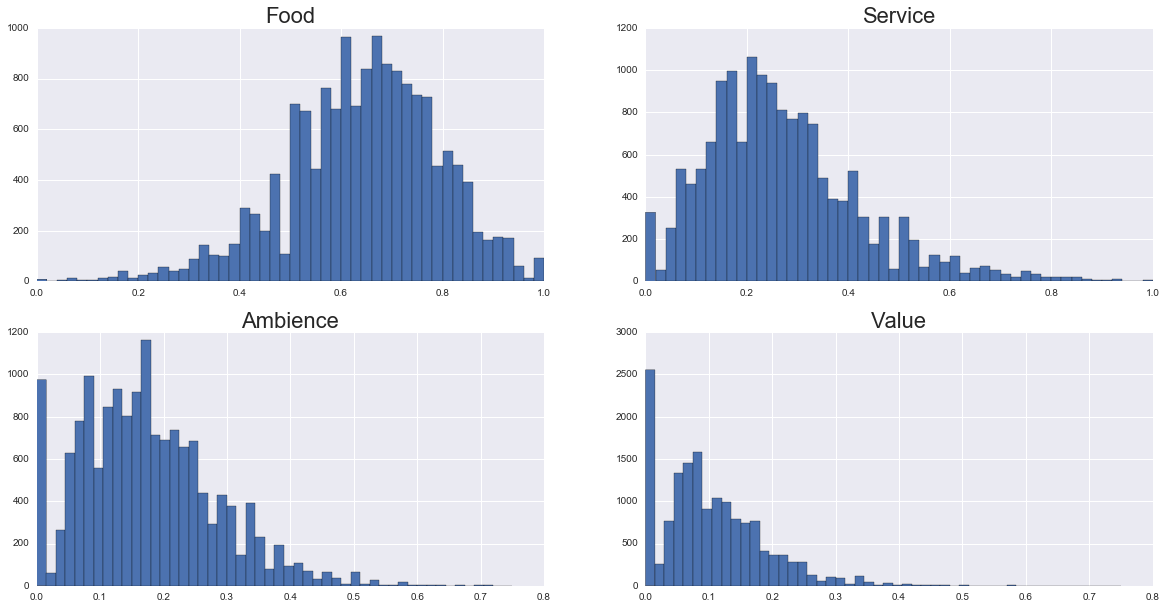

In [7]:
plt.figure(figsize=(20,10))

plt.subplot(2,2,1)
plt.hist(user.pct_food, bins=50)
plt.title("Food", fontsize=22)

plt.subplot(2,2,2)
plt.hist(user.pct_service, bins=50)
plt.title("Service", fontsize=22)

plt.subplot(2,2,3)
plt.hist(user.pct_ambience, bins=50)
plt.title("Ambience", fontsize=22)

plt.subplot(2,2,4)
plt.hist(user.pct_value, bins=50)
plt.title("Value", fontsize=22)

#### Apply PCA for Dimentionality Reduction

In [8]:
reducer = PCA(n_components=2, whiten=True)
reduced = reducer.fit_transform(user[["pct_food","pct_service","pct_ambience","pct_value"]])

reduced = pd.DataFrame(reduced, columns=["PCA_1", "PCA_2"])
reduced.head(5)

,PCA_1,PCA_2
0,-1.082740,0.792646
1,-0.787806,0.547124
2,0.166272,-0.684023
3,1.620466,0.799437
4,0.131627,-0.135445


In [9]:
user = pd.concat([user, reduced], axis=1)
user.head(5)

,location,user_id,topic_food,topic_service,topic_ambience,topic_value,relevant,total,pct_food,pct_service,pct_ambience,pct_value,PCA_1,PCA_2
0,"Charlotte, NC",qEOUrhX7uhB-9D7uTAKyJg,10,2,1,1,12,20,0.833333,0.166667,0.083333,0.083333,-1.082740,0.792646
1,"Charlotte, NC",VlCIxw9UOTxLTfE-dMWw0A,9,2,1,1,12,18,0.750000,0.166667,0.083333,0.083333,-0.787806,0.547124
2,"Charlotte, NC",9jLgxE6Bltubt7Ri4jTC9A,7,3,3,0,12,16,0.583333,0.250000,0.250000,0.000000,0.166272,-0.684023
3,"Charlotte, NC",KDioFcWlX7avlvftBPDpLQ,6,7,2,1,12,27,0.500000,0.583333,0.166667,0.083333,1.620466,0.799437
4,"Charlotte, NC",ctax9ECmvdyYqZJL-XG0pQ,7,3,2,0,12,16,0.583333,0.250000,0.166667,0.000000,0.131627,-0.135445


In [10]:
user.location.value_counts()

Charlotte, NC    6878
Pittsburg, PA    5239
Madison, WI      3432
Name: location, dtype: int64

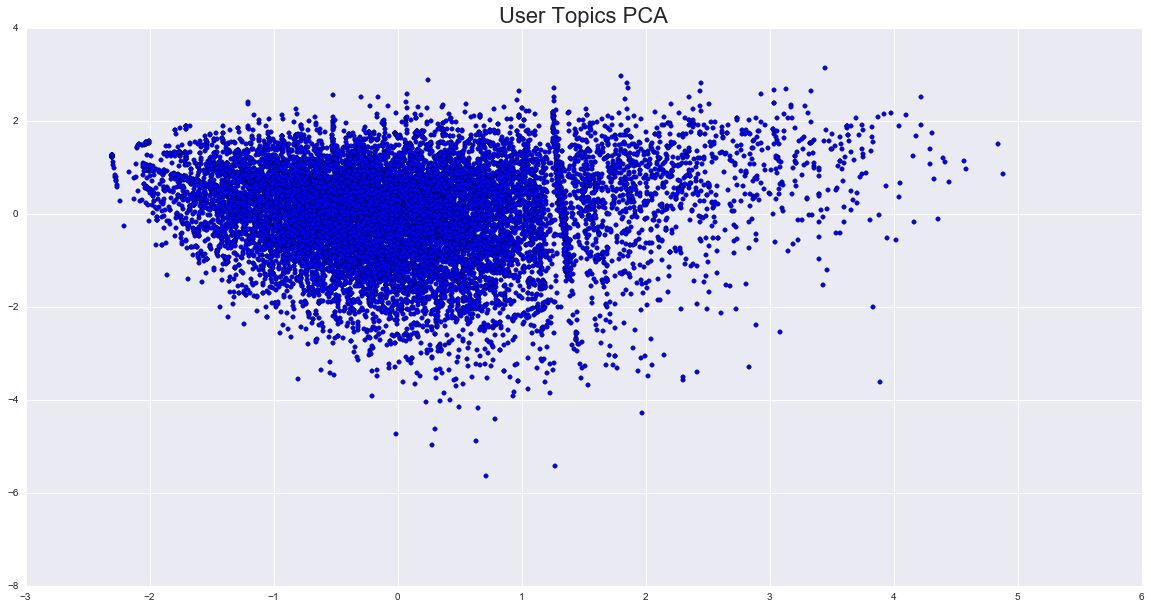

In [11]:
plt.figure(figsize=(20,10))
plt.scatter(user.PCA_1, user.PCA_2)
plt.title("User Topics PCA", fontsize=22)

#### Do We Get The Same Results with NMF? - check this out later

#### Cluster!!

In [12]:
def dbscan(df, eps, min_samples):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    clusters = pd.Series(dbscan.fit_predict(df[["PCA_1","PCA_2"]]), name="cluster")
    
    return pd.concat([df, clusters], axis=1)

2


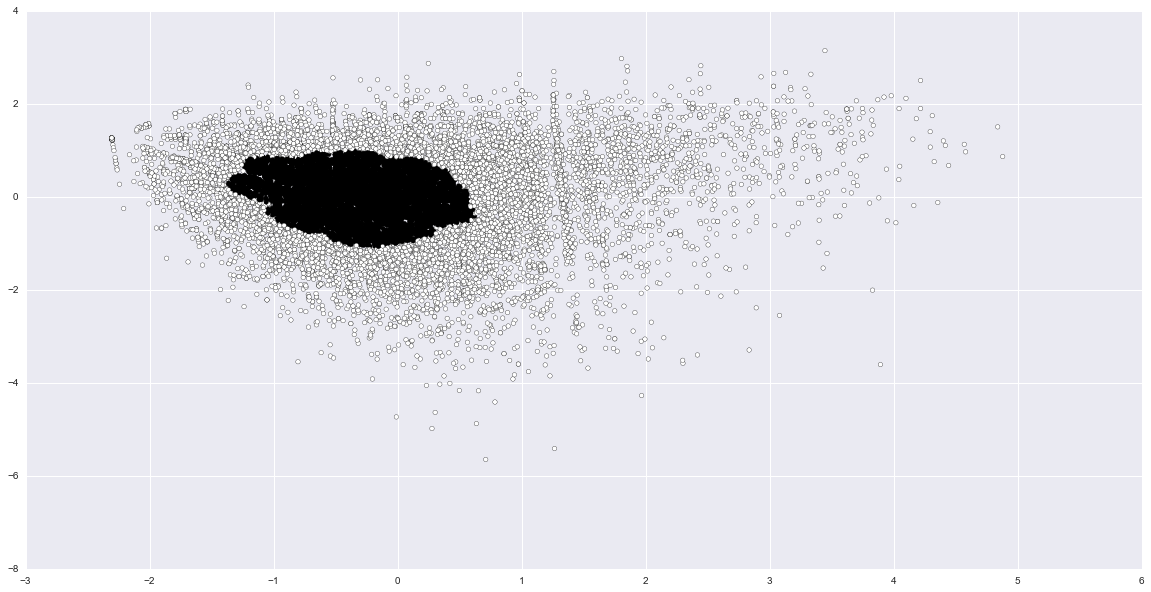

In [34]:
plt.figure(figsize=(20,10))
clustered = dbscan(user, eps=0.17, min_samples=200)

print clustered["cluster"].nunique()
plt.scatter(clustered.PCA_1, clustered.PCA_2, c=clustered.cluster, label=clustered.cluster)

Money! - with parameters eps=0.17 and min_samples=0.75 we've managed to split out people out into outliers and core

#### Let's Look at the chacteristics of our two clusters

In [35]:
def plot_by_cluster(df):
    sub0 = df[df.cluster==0]
    sub1 = df[df.cluster==-1]
    
    plt.figure(figsize=(20,10))
    plt.subplot(1,2,1)
    plt.scatter(sub0.PCA_1, sub0.PCA_2)
    plt.title("Cluster 0", fontsize=20)
    
    plt.subplot(1,2,2)
    plt.scatter(sub1.PCA_1, sub1.PCA_2)
    plt.title("Cluster -1", fontsize=20)

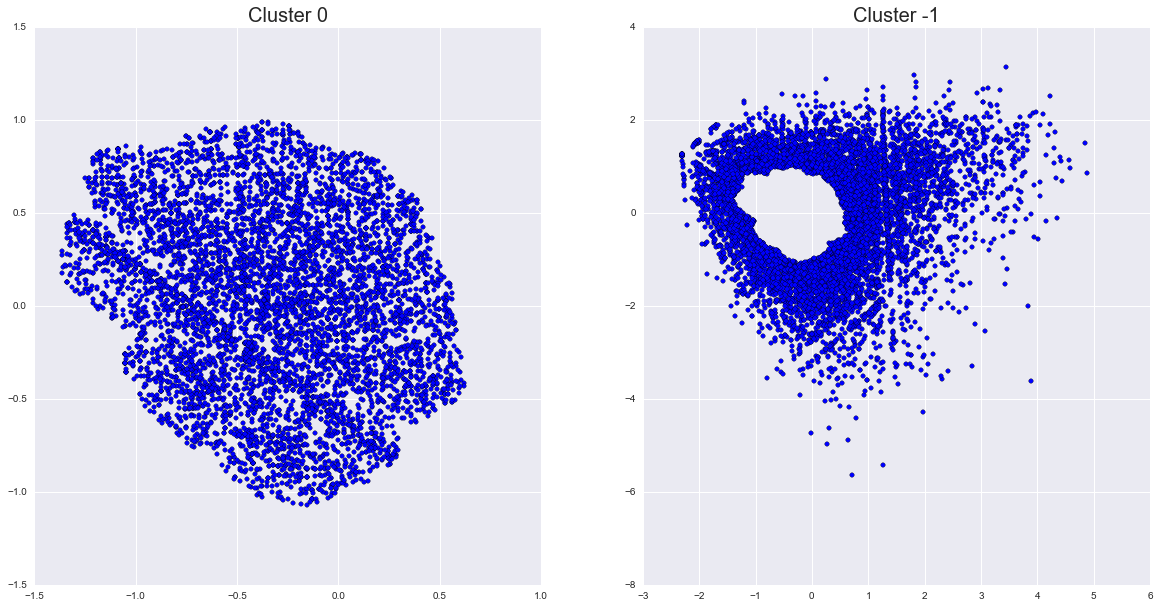

In [36]:
plot_by_cluster(clustered)

In [32]:
print clustered.cluster.value_counts()
print clustered.groupby(by="cluster")[["relevant","pct_food","pct_service","pct_ambience","pct_value"]].mean()
print clustered.groupby(by="cluster")[["pct_food","pct_service","pct_ambience","pct_value"]].std()

 0    10848
-1     4701
Name: cluster, dtype: int64
          relevant  pct_food  pct_service  pct_ambience  pct_value
cluster                                                           
-1       22.613486  0.559597     0.348897      0.196240   0.097474
 0       38.822179  0.679037     0.236178      0.165497   0.105720
         pct_food  pct_service  pct_ambience  pct_value
cluster                                                
-1       0.204444     0.222148      0.154210   0.086520
 0       0.100120     0.094621      0.077477   0.079344


#### Split Out into "Core" and "Outliers" and Cluster Further
* Core - KMeans
* Outliers - More DBSCAN to Parse out "Outliers" from "OMG So Much Outlier WHO ARE YOU?" (aka a sort of hierarchical-DBSCAN)